Mirroring an Image with Convolutional Networks
======

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [3]:
num_epochs = 5
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [8]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# function to mirror images horizontally
def flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1,
                                dtype=torch.long, device=x.device)
    return x[tuple(indices)]

Files already downloaded and verified
Files already downloaded and verified


ConvNet Definition
-----------------------
We use a convnet to mirror the images.

In [5]:
# UNet from: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

# Defines the Unet generator.
# |num_downs|: number of downsamplings in UNet. For example,
# if |num_downs| == 7, image of size 128x128 will become of size 1x1
# at the bottleneck
class UNet(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UNet, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        use_bias = False
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

net = UNet(3, 3, 5, 8)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
net = net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 261715


Train ConvNet
--------


In [5]:
optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)

# set to training mode
net.train()

train_loss_avg = []

print('number of batches per epoch: %d' % len(train_dataloader))

print('Training ...')
step = 0
train_loss = []
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        target_batch = flip(image_batch, dim=3)
        
        network_output = net(image_batch)
        
        loss = F.mse_loss(network_output, target_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        if step % 100 == 0:
            print('step %d loss: %f' % (step, loss.item()))
        
        train_loss.append(loss.item())
        
        step += 1

number of batches per epoch: 391
Training ...
step 0 loss: 0.265576
step 100 loss: 0.071243
step 200 loss: 0.055440
step 300 loss: 0.047969
step 400 loss: 0.042211
step 500 loss: 0.038213
step 600 loss: 0.037855
step 700 loss: 0.036787
step 800 loss: 0.031715
step 900 loss: 0.032572
step 1000 loss: 0.030967
step 1100 loss: 0.030151
step 1200 loss: 0.032924
step 1300 loss: 0.026158
step 1400 loss: 0.028102
step 1500 loss: 0.031092
step 1600 loss: 0.026438
step 1700 loss: 0.028534
step 1800 loss: 0.029575
step 1900 loss: 0.029093


Plot Training Curve
--------------------

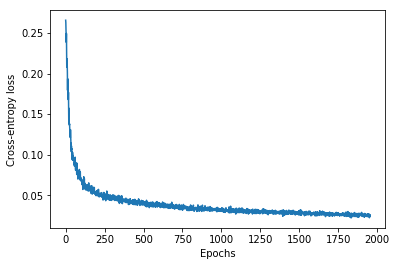

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show();

Alternatively: Load Pre-Trained Model
-----------------------------

In [6]:
filename = 'mirroring_network.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
net.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the model parameters can be saved:
# torch.save(net.state_dict(), './pretrained/mirroring_network.pth')

downloading ...
done


Evaluate on the Test Set
-------------------------

The mirrored images are much lower-resolution than the original images. This is due to the locality of convolution kernels: at a given output pixel, information from distant parts of the images, like the opposite edge of the image, are only available in low resolution.

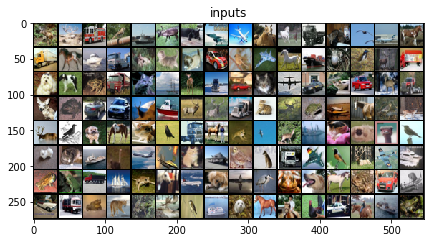

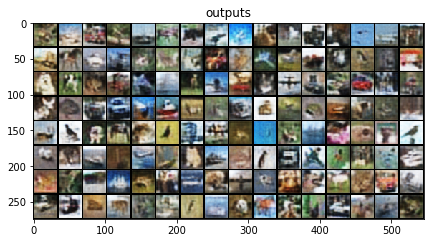

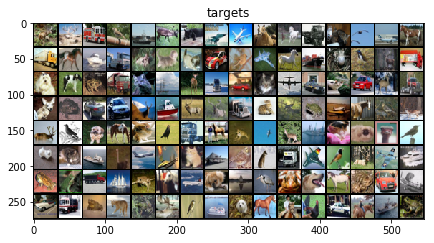

In [9]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

# set to evaluation mode
net.eval()

with torch.no_grad():
    image_batch, label_batch = next(iter(test_dataloader))
    image_batch = image_batch.to(device)
    
    network_output = net(image_batch)
    network_output = network_output.cpu()
    image_batch = image_batch.cpu()
    target_batch = flip(image_batch, dim=3)
       
    fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(image_batch*0.5+0.5, nrow=16).numpy(), (1, 2, 0)))
    ax.title.set_text('inputs')

    fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(network_output*0.5+0.5, nrow=16).numpy(), (1, 2, 0)))
    ax.title.set_text('outputs')

    fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(target_batch*0.5+0.5, nrow=16).numpy(), (1, 2, 0)))
    ax.title.set_text('targets')